Python notebook using data from https://www.kaggle.com/c/dogs-vs-cats/data

This Kernel for someone want to deep dive into image classification. I use CNN for classification model. 

In [1]:
# Import The Libraries

import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir())

['.ipynb_checkpoints', 'cat_vs_dog.ipynb', 'dataset']


## Prepare Traning Data

In [2]:
filenames = os.listdir('dataset/train')
categories = []
for filename in filenames: 
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else :
        categories.append(0)

df= pd.DataFrame({'filename': filenames,
                  'category': categories})

In [3]:
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [4]:
df.tail()

,filename,category
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1
24999,dog.9999.jpg,1


<AxesSubplot:>

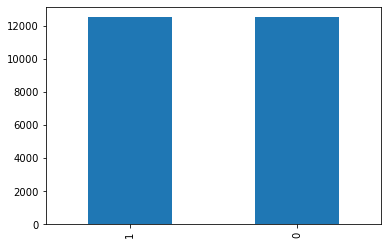

In [5]:
df.category.value_counts().plot.bar()

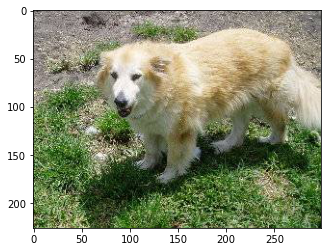

In [6]:
# See Sample
sample = random.choice(filenames)
image = load_img('dataset/train/'+sample)
plt.imshow(image)

## Build The CNN 

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

cnn = Sequential()

cnn.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (128, 128, 3)))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size= (2, 2)))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(64, (3, 3), activation = 'relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size= (2, 2)))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(128, (3, 3), activation = 'relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size= (2, 2)))
cnn.add(Dropout(0.25))

cnn.add(Flatten())
cnn.add(Dense(512, activation = 'relu'))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.5))
cnn.add(Dense(2, activation = 'softmax'))

In [8]:
cnn.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [9]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

## Callbacks 

In [10]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

### Early Stop

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased 

In [11]:
earlystop = EarlyStopping(patience=10)

### Learning Rate Reduction

We will reduce the learning rate when the accuracy not increase for 2 steps 

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [13]:
callbacks = [earlystop, learning_rate_reduction]

### Prepare Data
Because we will use image genaretor with class_mode="categorical". We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification.

So we will convert 1 to dog and 0 to cat

In [14]:
df.category = df.category.replace({0 : 'cat', 1 : 'dog'})

In [15]:
train_df, test_df = train_test_split(df, test_size = 0.20, random_state= 42)
train_df = train_df.reset_index(drop = True)
test_df = test_df.reset_index(drop = True)

<AxesSubplot:>

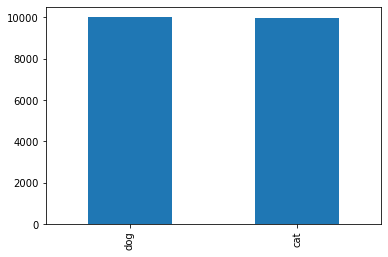

In [16]:
train_df.category.value_counts().plot.bar()

<AxesSubplot:>

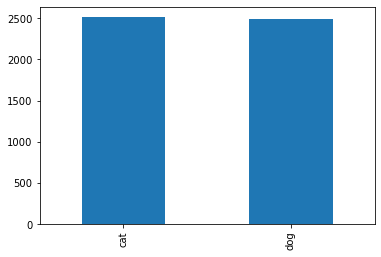

In [17]:
test_df.category.value_counts().plot.bar()

In [18]:
total_train = train_df.shape[0]
total_test = test_df.shape[0]
batch_size=15

## Traning Generator 

In [19]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "dataset/train/", 
    x_col='filename',
    y_col='category',
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


## Testing Generator 

In [20]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    "dataset/train/", 
    x_col='filename',
    y_col='category',
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


## See how our generator work

In [21]:
sample_df = train_df.sample(n= 1).reset_index(drop = True)
sample_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "dataset/train/", 
    x_col='filename',
    y_col='category',
    target_size=(128, 128),
    class_mode='categorical',
)

Found 20000 validated image filenames belonging to 2 classes.


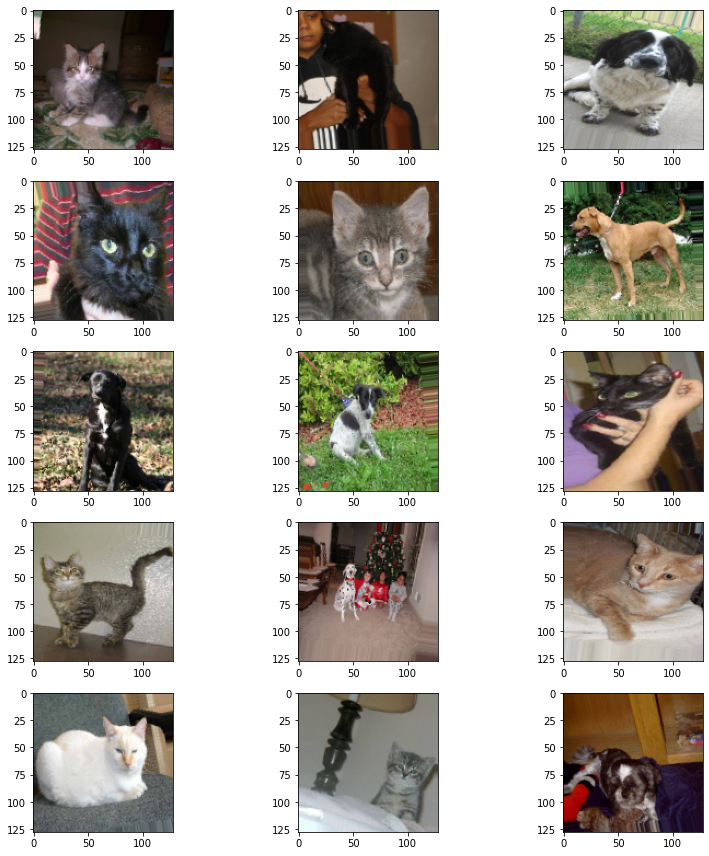

In [22]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in sample_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## Fit Model

In [23]:
FAST_RUN = False
epochs=3 if FAST_RUN else 11
history = cnn.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=total_test//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
    
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/11
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1333/1333 [==============================] - ETA: 0s - loss: 0.7430 - accuracy: 0.6303WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001758B1F1EA0> and will run it as-is.
Please report this to the TensorFlow team. When fili

In [40]:
!pip install PyYAML

In [43]:
model_yaml = cnn.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
cnn.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


## Prepare Testing Data

In [25]:
test_filenames = os.listdir("dataset/test/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

## Create Testing Generator 

In [26]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "dataset/test/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(128, 128),
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


## Predict 

In [27]:
predict = cnn.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

Instructions for updating:
Please use Model.predict, which supports generators.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


For categoral classication the prediction will come with probability of each category. So we will pick the category that have the highest probability with numpy average max

In [28]:
test_df['category'] = np.argmax(predict, axis=-1)

We will convert the predict category back into our generator classes by using train_generator.class_indices. It is the classes that image generator map while converting data into computer vision 

In [29]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [30]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

## See predicted result with images 

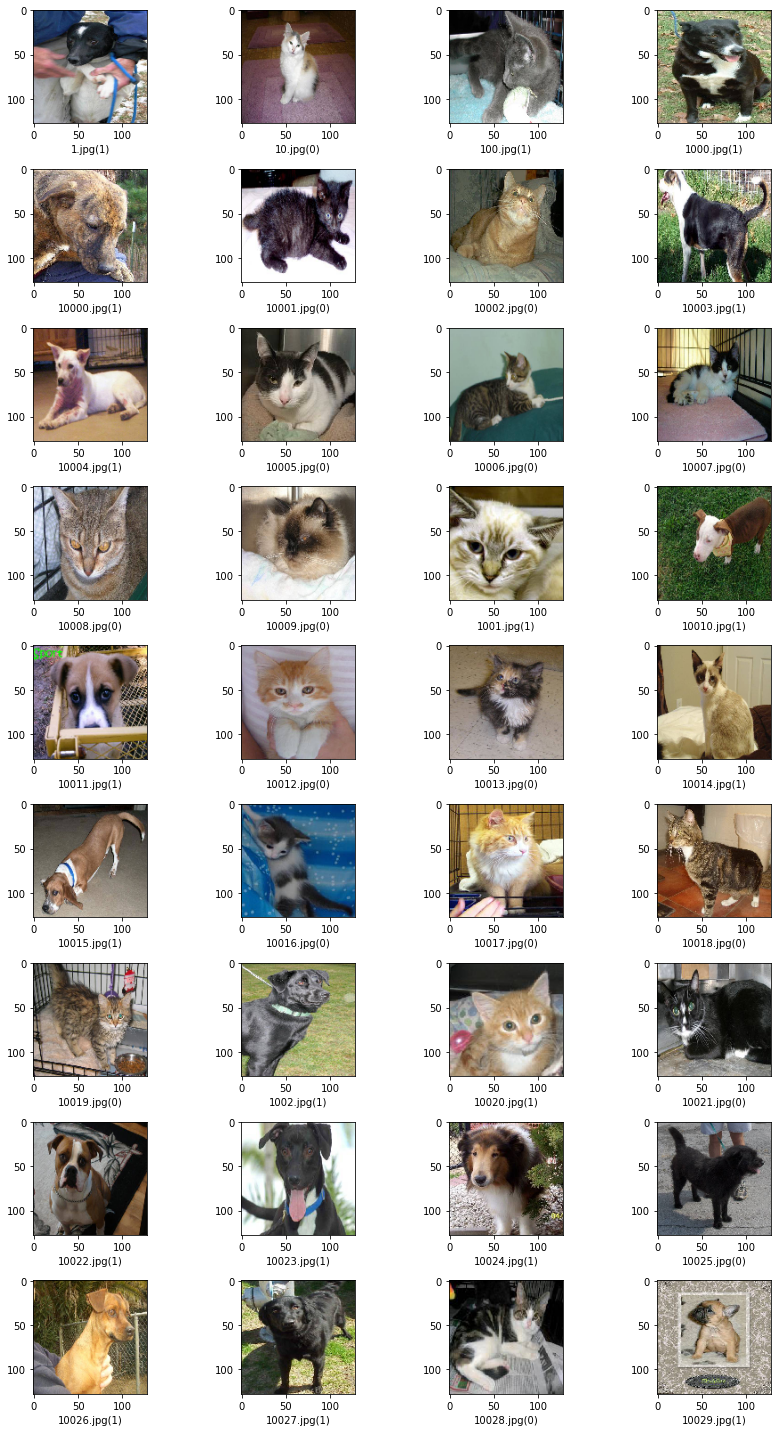

In [39]:
sample_test = test_df.head(36)
sample_test.head()
plt.figure(figsize=(12, 20))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("dataset/test/"+filename, target_size=(128, 128))
    plt.subplot(9, 4, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()

plt.show()